In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Set seed for reproducibility
torch.manual_seed(69)

In [3]:
# Define device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Data transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.RandomRotation(10),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
])

# Load dataset
DATA_DIR = "C:/Dev/Python_Project/Brain_Tumour_Classification/mrimages/Data"
full_dataset = ImageFolder(root=DATA_DIR, transform=test_transform)

# Accessing classes in the dataset
classes = full_dataset.classes

# Print the classes
print("Classes in the dataset:", classes)

Classes in the dataset: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [13]:
# Splitting the dataset
test_size = 0.1
val_size = 0.2
train_size = 1.0 - test_size - val_size

len_test = int(test_size * len(full_dataset))
len_val = int(val_size * len(full_dataset))
len_train = len(full_dataset) - len_test - len_val

assert len_test + len_train + len_val == len(full_dataset)

test_dataset, validation_dataset, train_dataset = random_split(full_dataset, [len_test, len_val, len_train])

# Print shapes after splitting
print(
    f"Shapes after splitting:\n\nTrain: {len(train_dataset)}\
      \nValidation: {len(validation_dataset)}\
      \nTest: {len(test_dataset)}\n\n\
      \nFullDataset: {len(full_dataset)}"
)

Shapes after splitting:

Train: 2168      
Validation: 619      
Test: 309

      
FullDataset: 3096


In [14]:
# Data loaders
NUM_WORKERS = 2
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Class mappings
class_to_idx = full_dataset.class_to_idx
idx_to_class = {idx: label for label, idx in full_dataset.class_to_idx.items()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


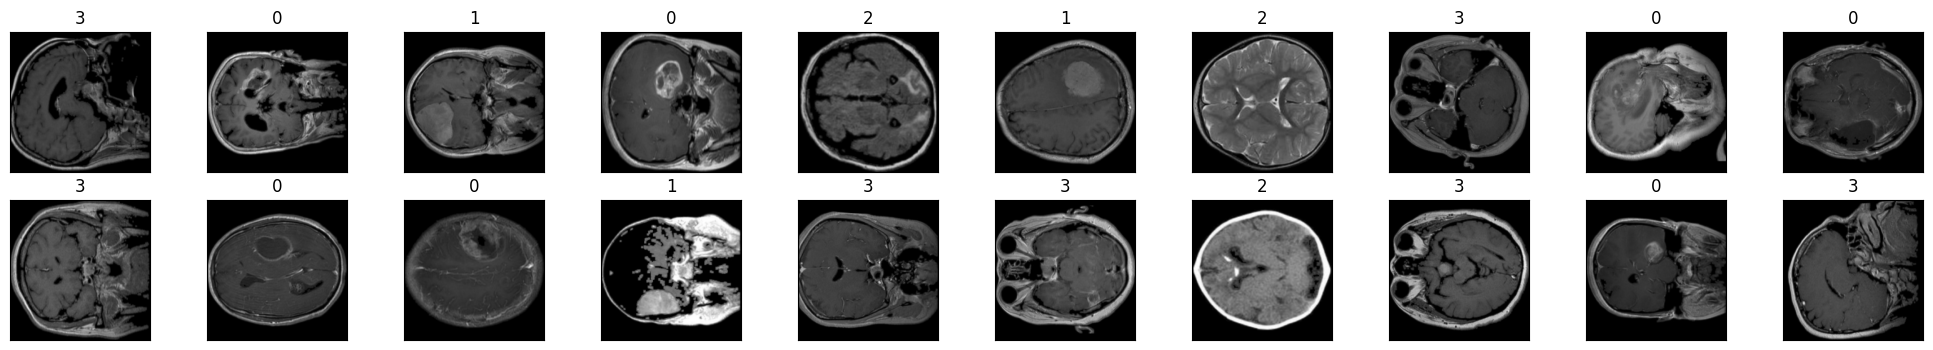

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images in a 2x10 grid
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(images[idx].T)
    ax.set_title(str(labels[idx].item()))

# Show the plot
plt.show()

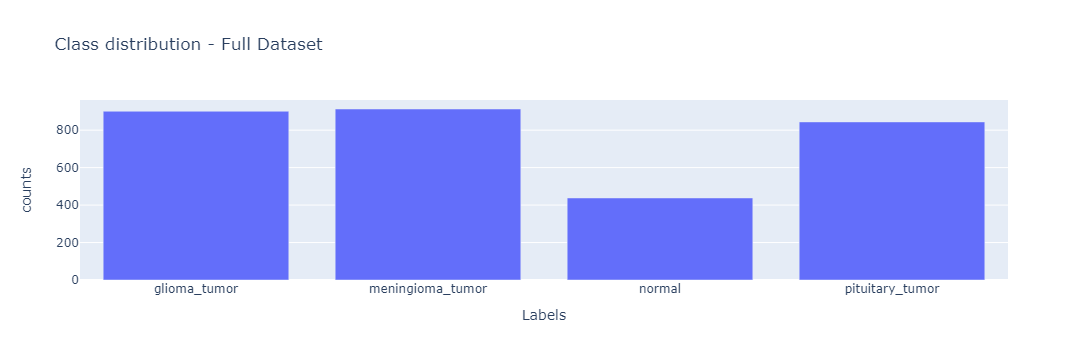

In [16]:
# Plot class distribution for the full dataset
labels_df = pd.DataFrame(full_dataset.targets, columns=["Labels"]).replace(idx_to_class)

import plotly.express as px

fig = px.bar(
    labels_df.groupby(["Labels"]).size().reset_index(name='counts'),
    x="Labels",
    y="counts",
    title="Class distribution - Full Dataset"
)
fig.show()

In [17]:
# Define EfficientNet model
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# Create an instance of the model
NUM_CLASSES = 4
model = EfficientNetModel(NUM_CLASSES).to(DEVICE)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Loaded pretrained weights for efficientnet-b0


In [19]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Print statistics
        val_accuracy = correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Epoch 1/25, Loss: 0.2621, Validation Accuracy: 0.9273
Epoch 2/25, Loss: 0.2629, Validation Accuracy: 0.9321
Epoch 3/25, Loss: 0.2385, Validation Accuracy: 0.9435
Epoch 4/25, Loss: 0.2262, Validation Accuracy: 0.9467
Epoch 5/25, Loss: 0.1831, Validation Accuracy: 0.9580
Epoch 6/25, Loss: 0.1847, Validation Accuracy: 0.9596
Epoch 7/25, Loss: 0.1743, Validation Accuracy: 0.9564
Epoch 8/25, Loss: 0.2028, Validation Accuracy: 0.9612
Epoch 9/25, Loss: 0.2062, Validation Accuracy: 0.9596
Epoch 10/25, Loss: 0.2013, Validation Accuracy: 0.9596
Epoch 11/25, Loss: 0.2107, Validation Accuracy: 0.9645
Epoch 12/25, Loss: 0.2263, Validation Accuracy: 0.9612
Epoch 13/25, Loss: 0.2412, Validation Accuracy: 0.9402
Epoch 14/25, Loss: 0.2090, Validation Accuracy: 0.9596
Epoch 15/25, Loss: 0.2306, Validation Accuracy: 0.9532
Epoch 16/25, Loss: 0.1891, Validation Accuracy: 0.9612
Epoch 17/25, Loss: 0.2222, Validation Accuracy: 0.9596
Epoch 18/25, Loss: 0.2312, Validation Accuracy: 0.9580
Epoch 19/25, Loss: 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       106
           1       0.93      1.00      0.96        67
           2       1.00      1.00      1.00        52
           3       0.99      1.00      0.99        84

    accuracy                           0.98       309
   macro avg       0.98      0.99      0.98       309
weighted avg       0.98      0.98      0.98       309



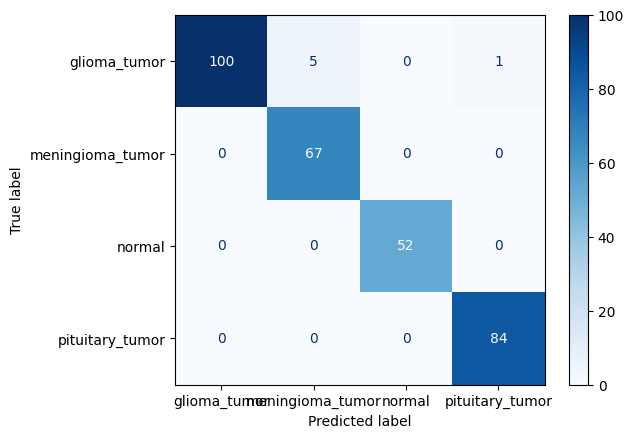

Accuracy: 98.06%
Precision (weighted): 98.17%
Recall (weighted): 98.06%
F1-score (weighted): 98.06%
ROC-AUC: 98.98%


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate on test set
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# Generate classification report for the entire dataset
print("Classification Report:")
print(classification_report(all_targets, all_predictions))

# Generate confusion matrix for the entire dataset
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix using sklearn's plot_confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_to_idx.keys()))
disp.plot(cmap=plt.cm.Blues, values_format='g')

# Show plot
plt.show()

# Additional Metrics
accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(all_targets), pd.get_dummies(all_predictions), multi_class='ovr')

# Print additional metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (weighted): {precision * 100:.2f}%")
print(f"Recall (weighted): {recall * 100:.2f}%")
print(f"F1-score (weighted): {f1 * 100:.2f}%")
print(f"ROC-AUC: {roc_auc * 100:.2f}%")